In [1]:
!pip install torch

In [16]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.functional as Func
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset
import random
from scipy.io import savemat
import os
from os import path
from sklearn.preprocessing import normalize
from torch.nn.utils import clip_grad_norm_
import torch.nn.parallel.data_parallel as data_parallel
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR, ReduceLROnPlateau

### Loading the dataset as key value pair

In [17]:
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [18]:
mnist

{'DESCR': "**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered i

In [19]:
import numpy as np
X,y=mnist["data"],mnist["target"]
y=y.astype(int)
X=((X/255.)-.5)*2
print(X.shape,y.shape)
print(min(y),max(y))
print(type(X),type(y))
print(np.min(X), np.max(X))

(70000, 784) (70000,)
0 9
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
-1.0 1.0


### Splittling the data into train and test

In [20]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(60000, 784) (10000, 784) (60000,) (10000,)


### Splliting the train data further into train and development/validation

In [21]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state = 42)

for train_index, val_index in split.split(X_train,y_train):
    X_train_strat = X[train_index,:]
    y_train_strat = y[train_index]
    
    X_dev_strat = X[val_index,:]
    y_dev_strat = y[val_index]

print(X_train_strat.shape,y_train_strat.shape,X_dev_strat.shape,y_dev_strat.shape)

(54000, 784) (54000,) (6000, 784) (6000,)


In [22]:
train_images = X_train_strat.reshape(X_train_strat.shape[0], 28, 28) #reshape the images to 54000,28,28 from 54000,784
dev_images = X_dev_strat.reshape(X_dev_strat.shape[0], 28, 28)
test_images = X_test.reshape(X_test.shape[0], 28, 28)

### Converting the data into tensor format for the input to the CNN model

In [23]:
#train
train_images_tensor = torch.tensor(train_images)/255.0
train_labels_tensor = torch.tensor(y_train_strat)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)

#dev
dev_images_tensor = torch.tensor(dev_images)/255.0
dev_labels_tensor = torch.tensor(y_dev_strat)
dev_tensor = TensorDataset(dev_images_tensor, dev_labels_tensor)

#test
test_images_tensor = torch.tensor(test_images)/255.0

### Calling Data Loader to save the input tensors 

In [24]:
train_loader = DataLoader(train_tensor, batch_size=16, num_workers=2, shuffle=True)
dev_loader = DataLoader(dev_tensor, batch_size=16, num_workers=2, shuffle=True)
test_loader = DataLoader(test_images_tensor, batch_size=16, num_workers=2, shuffle=False)

### Define hyperparameters

In [25]:
class hyperparam:
    lr = 0.05  # learning rate
    num_epochs = 50  # Number of epochs
    bs = 16  # Mini-batch size 
    moment = 0.9 # Momentum SGD 

### **Droupout rate is 0.25**

### Creating the CNN Architechture with 3 convolution layers and 3 maxpool layers along with activation functions after each convolution and pooling layer. Then passing the output of the convolution block to the fully connected layers with 2 hidden and one output layer. 


In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            #nn.Dropout(p=0.25),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

### Glorat Intialization using xavier normal function in torch

In [13]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)

### Call the CNN model and define loss function

In [14]:
cnn_model = CNN()
cnn_model.apply(init_weights) # glorat initialization 
cnn_model.parameters()

<generator object Module.parameters at 0x7fdc407499d0>

### Initializing three things in the next cell:
### 1) Optimizer as Stochastic Gradient Descent with learning rate of 0.05 and momentum of 0.9
### 2) Learning Rate scheduler to adjust the learning rate by 10% every 10 epochs
### 3) Cross Entropy Loss function since its a classification problem

In [15]:
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=hyperparam.lr, momentum=hyperparam.moment)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    print('Avaialble')
    cnn_model = cnn_model.cuda()
    criterion = criterion.cuda()

Avaialble


### Training the model and validating side by side to check the results

### Printing the accuracy and loss of train and validation set

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


accuracy 79.15185185185184 11.233333333333333
accuracy 88.30740740740741 11.233333333333333
accuracy 90.55 9.9
accuracy 91.8462962962963 11.233333333333333
accuracy 92.85740740740741 9.733333333333333
accuracy 93.19259259259259 11.233333333333333
accuracy 93.90185185185184 11.233333333333333
accuracy 93.88518518518518 10.45
accuracy 94.1962962962963 11.233333333333333
accuracy 95.04444444444445 10.216666666666667
accuracy 95.49814814814815 20.166666666666668
accuracy 95.63888888888889 28.616666666666667
accuracy 95.67037037037036 41.63333333333333
accuracy 95.95 23.583333333333332
accuracy 95.95185185185186 11.966666666666667
accuracy 95.91296296296296 26.533333333333335
accuracy 96.05740740740741 17.716666666666665
accuracy 96.06851851851852 24.383333333333333
accuracy 96.3537037037037 10.333333333333334
accuracy 96.32592592592593 84.8
accuracy 96.41481481481482 97.26666666666667
accuracy 96.37037037037037 75.05
accuracy 96.24259259259259 74.9
accuracy 96.44814814814815 86.25
accuracy

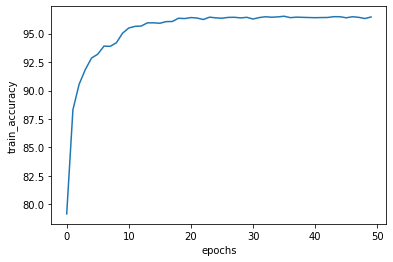

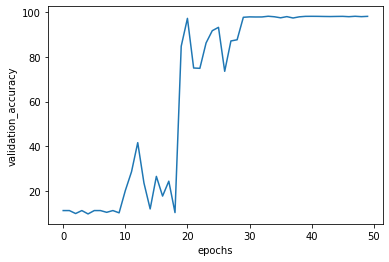

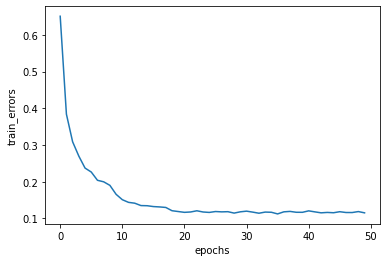

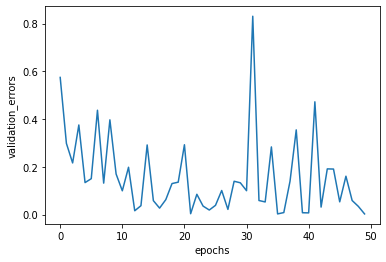

In [16]:
#Train the CNN
tr_avgLoss_list = []
tr_accuracy_list =[]
dev_avgLoss_list = []
dev_accuracy_list = []

#loop over epochs
for epoch in range(hyperparam.num_epochs):
    tr_num_correct = 0
    tr_num_samples = 0
    tr_total_loss = 0.0
    dev_num_correct = 0
    dev_num_samples = 0
    dev_total_loss = 0.0
    
    #Training
    cnn_model.train(True) 
    scheduler.step()  #to decrease the lr by 10% every 10 epochs because as you move towards the minima the steps size needs to decrease so it doesnt jump over the minima
    with torch.set_grad_enabled(True):
        for local_batch, local_labels in train_loader:
            local_batch=local_batch.unsqueeze(1)
            
            if torch.cuda.is_available():
              local_batch = local_batch.cuda()
              local_labels = local_labels.cuda()
            
            optimizer.zero_grad()
            
            
            local_batch = local_batch.float()
            local_labels = local_labels.float()
            #local_batch, local_labels = Variable(local_batch), Variable(local_labels)
            
            #Model computations
            out1 = cnn_model(local_batch)
            
            #Cross Entropy loss calculation
            ploss = criterion(out1, local_labels.long())
            tr_total_loss += ploss*hyperparam.bs
            
            #Backpropogation
            ploss.backward() #gradient calculation
            optimizer.step() #weight update
           
            
            sel_class = torch.argmax(out1, dim=1) #chooses the maximum value of the softmax layer
            
            tr_num_correct += sel_class.eq(local_labels).sum().item()
            tr_num_samples += hyperparam.bs
        
        tr_avgLoss = tr_total_loss/len(train_loader.dataset)
        tr_avgLoss_list.append(tr_avgLoss)
        
        tr_accuracy = tr_num_correct*100/tr_num_samples 
        tr_accuracy_list.append(tr_accuracy)

    #validation 
    with torch.set_grad_enabled(False):
      cnn_model.eval()

      for local_batch,local_labels in dev_loader:
        local_batch=local_batch.unsqueeze(1)

        local_batch=local_batch.float()
        local_labels=local_labels.float()
        #local_batch,local_labels=Variable(local_batch),Variable(local_labels)
        
        if torch.cuda.is_available():
            local_batch = local_batch.cuda()
            local_labels = local_labels.cuda()
        #Model computations2
        out1=cnn_model(local_batch)

        #CrossEntropy loss calculation
        pLoss=criterion(out1,local_labels.long())
        dev_total_loss +=ploss*hyperparam.bs
        sel_class=torch.argmax(out1,dim=1)

        dev_num_correct+=sel_class.eq(local_labels).sum().item()

        #print(correction)
        dev_num_samples+=hyperparam.bs

      dev_avgLoss=dev_total_loss/len(dev_loader.dataset)
      dev_avgLoss_list.append(dev_avgLoss)

      dev_accuracy=dev_num_correct*100/dev_num_samples
      dev_accuracy_list.append(dev_accuracy)
    print("accuracy",tr_accuracy,dev_accuracy)

plt.plot(np.arange(0,hyperparam.num_epochs,1),tr_accuracy_list)
plt.xlabel("epochs")
plt.ylabel("train_accuracy")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),dev_accuracy_list)
plt.xlabel("epochs")
plt.ylabel("validation_accuracy")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),tr_avgLoss_list)
plt.xlabel("epochs")
plt.ylabel("train_errors")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),dev_avgLoss_list)
plt.xlabel("epochs")
plt.ylabel("validation_errors")
plt.show()

### From the above diagram we can say that the model overfits a little as for the validation set we can see that it varies up and down slighlty over the epochs whereas for training it is smooth increase for accuracy and smooth decrease for loss. 

In [17]:
def make_predictions(data_loader):
    cnn_model.eval()
    test_preds = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1) #adds a dimension of the length 1
        
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = cnn_model(data.float()) #convert to float here as well
        
        preds = output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
        
    return test_preds

In [18]:
test_set_preds = make_predictions(test_loader)
test_set_preds

tensor([[7],
        [2],
        [1],
        ...,
        [4],
        [5],
        [6]])

In [19]:
submission_df=pd.DataFrame()
submission_df["label"]=test_set_preds.numpy().squeeze()
submission_df.head()

,label
0,7
1,2
2,1
3,0
4,4


### Confusion Matrix of testing set
### Accuracy of the testing set

In [20]:
from sklearn.metrics import confusion_matrix

y_true = mnist["target"][60000:].astype(int)
y_pred = np.array(submission_df["label"])
cf = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true,y_pred)
print("Accuracy of the test set is:",acc*100,"%")
print("Confusion matrix for the test set: \n",cf)

Accuracy of the test set is: 98.37 %
Confusion matrix for the test set: 
 [[ 976    0    1    0    0    0    1    1    1    0]
 [   0 1125    2    2    0    0    4    1    1    0]
 [   1    0 1021    2    1    0    0    4    3    0]
 [   0    0    2  991    0    6    0    5    4    2]
 [   1    3    1    1  959    0    2    0    1   14]
 [   2    0    0    7    0  876    3    0    1    3]
 [   5    2    1    0    1    3  942    0    4    0]
 [   0    2    9    2    1    0    0 1007    2    5]
 [   0    0    2    3    0    4    1    4  957    3]
 [   1    2    0    3    3    5    0    4    8  983]]


#### Thus, the accuracy of the baseline system is almost 98 which suggests that the model is performing well. The confusion matrix also gives good results as the count around the diagonal is high which is ideal.

### **Droupout rate is 0.5**

### Creating the CNN Architechture with 3 convolution layers and 3 maxpool layers along with activation functions after each convolution and pooling layer. Then passing the output of the convolution block to the fully connected layers with 2 hidden and one output layer.


In [21]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

### Glorat Intialization using xavier normal function in torch

In [22]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)

### Call the CNN model and define loss function

In [23]:
cnn_model = CNN()
cnn_model.apply(init_weights) # glorat initialization 
cnn_model.parameters()

<generator object Module.parameters at 0x7fdc408088d0>

### Initializing three things in the next cell:
### 1) Optimizer as Stochastic Gradient Descent with learning rate of 0.05 and momentum of 0.9
### 2) Learning Rate scheduler to adjust the learning rate by 10% every 10 epochs
### 3) Cross Entropy Loss function since its a classification problem

In [24]:
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=hyperparam.lr, momentum=hyperparam.moment)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    print('Avaialble')
    cnn_model = cnn_model.cuda()
    criterion = criterion.cuda()

Avaialble


### Training the model and validating side by side to check the results

### Printing the accuracy and loss of train and validation set

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


accuracy 79.7611111111111 10.45
accuracy 89.76666666666667 9.866666666666667
accuracy 91.63333333333334 11.233333333333333
accuracy 92.43148148148148 11.233333333333333
accuracy 93.44444444444444 12.3
accuracy 93.89814814814815 9.033333333333333
accuracy 94.12222222222222 13.633333333333333
accuracy 94.32777777777778 24.933333333333334
accuracy 94.66851851851852 29.633333333333333
accuracy 95.9074074074074 96.93333333333334
accuracy 96.25185185185185 98.25
accuracy 96.35740740740741 90.31666666666666
accuracy 96.43888888888888 98.7
accuracy 96.53518518518518 88.15
accuracy 96.54814814814814 96.36666666666666
accuracy 96.63888888888889 97.56666666666666
accuracy 96.65555555555555 97.86666666666666
accuracy 96.72222222222223 98.61666666666666
accuracy 96.68703703703704 97.35
accuracy 96.82962962962964 98.93333333333334
accuracy 96.7462962962963 98.96666666666667
accuracy 96.74814814814815 98.83333333333333
accuracy 96.82777777777778 99.0
accuracy 96.85185185185185 98.95
accuracy 96.88703

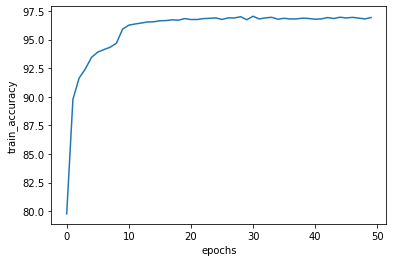

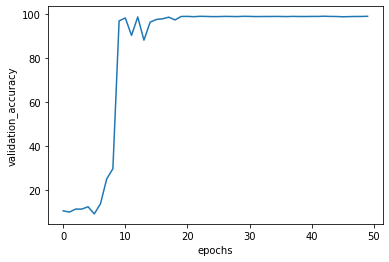

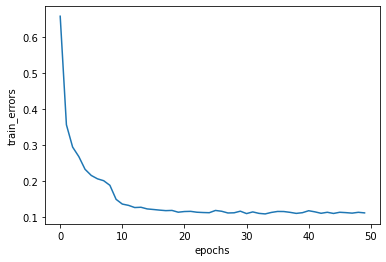

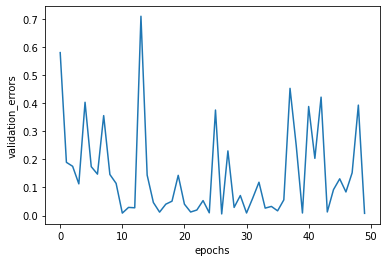

In [25]:
#Train the CNN
tr_avgLoss_list = []
tr_accuracy_list =[]
dev_avgLoss_list = []
dev_accuracy_list = []

#loop over epochs
for epoch in range(hyperparam.num_epochs):
    tr_num_correct = 0
    tr_num_samples = 0
    tr_total_loss = 0.0
    dev_num_correct = 0
    dev_num_samples = 0
    dev_total_loss = 0.0
    
    #Training
    cnn_model.train(True) 
    scheduler.step()  #to decrease the lr by 10% every 10 epochs because as you move towards the minima the steps size needs to decrease so it doesnt jump over the minima
    with torch.set_grad_enabled(True):
        for local_batch, local_labels in train_loader:
            local_batch=local_batch.unsqueeze(1)
            
            if torch.cuda.is_available():
              local_batch = local_batch.cuda()
              local_labels = local_labels.cuda()
            
            optimizer.zero_grad()
            
            
            local_batch = local_batch.float()
            local_labels = local_labels.float()
            #local_batch, local_labels = Variable(local_batch), Variable(local_labels)
            
            #Model computations
            out1 = cnn_model(local_batch)
            
            #Cross Entropy loss calculation
            ploss = criterion(out1, local_labels.long())
            tr_total_loss += ploss*hyperparam.bs
            
            #Backpropogation
            ploss.backward() #gradient calculation
            optimizer.step() #weight update
           
            
            sel_class = torch.argmax(out1, dim=1) #chooses the maximum value of the softmax layer
            
            tr_num_correct += sel_class.eq(local_labels).sum().item()
            tr_num_samples += hyperparam.bs
        
        tr_avgLoss = tr_total_loss/len(train_loader.dataset)
        tr_avgLoss_list.append(tr_avgLoss)
        
        tr_accuracy = tr_num_correct*100/tr_num_samples 
        tr_accuracy_list.append(tr_accuracy)

    #validation 
    with torch.set_grad_enabled(False):
      cnn_model.eval()

      for local_batch,local_labels in dev_loader:
        local_batch=local_batch.unsqueeze(1)

        local_batch=local_batch.float()
        local_labels=local_labels.float()
        #local_batch,local_labels=Variable(local_batch),Variable(local_labels)
        
        if torch.cuda.is_available():
            local_batch = local_batch.cuda()
            local_labels = local_labels.cuda()
        #Model computations2
        out1=cnn_model(local_batch)

        #CrossEntropy loss calculation
        pLoss=criterion(out1,local_labels.long())
        dev_total_loss +=ploss*hyperparam.bs
        sel_class=torch.argmax(out1,dim=1)

        dev_num_correct+=sel_class.eq(local_labels).sum().item()

        #print(correction)
        dev_num_samples+=hyperparam.bs

      dev_avgLoss=dev_total_loss/len(dev_loader.dataset)
      dev_avgLoss_list.append(dev_avgLoss)

      dev_accuracy=dev_num_correct*100/dev_num_samples
      dev_accuracy_list.append(dev_accuracy)
    print("accuracy",tr_accuracy,dev_accuracy)

plt.plot(np.arange(0,hyperparam.num_epochs,1),tr_accuracy_list)
plt.xlabel("epochs")
plt.ylabel("train_accuracy")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),dev_accuracy_list)
plt.xlabel("epochs")
plt.ylabel("validation_accuracy")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),tr_avgLoss_list)
plt.xlabel("epochs")
plt.ylabel("train_errors")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),dev_avgLoss_list)
plt.xlabel("epochs")
plt.ylabel("validation_errors")
plt.show()

### From the above diagram we can say that the model reasonably fits the validation data as it kind of follows the same trend for both train and dev for accuracy curve. The loss curve for validation varies a lot up and down but that is bound to happen since here the validation data is not updating weights like training.

In [26]:
def make_predictions(data_loader):
    cnn_model.eval()
    test_preds = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1) #adds a dimension of the length 1
        
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = cnn_model(data.float()) #convert to float here as well
        
        preds = output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
        
    return test_preds

In [27]:
test_set_preds = make_predictions(test_loader)
test_set_preds

tensor([[7],
        [2],
        [1],
        ...,
        [4],
        [5],
        [6]])

In [28]:
submission_df=pd.DataFrame()
submission_df["label"]=test_set_preds.numpy().squeeze()
submission_df.head()

,label
0,7
1,2
2,1
3,0
4,4


### Confusion Matrix of testing set
### Accuracy of the testing set

In [29]:
from sklearn.metrics import confusion_matrix

y_true = mnist["target"][60000:].astype(int)
y_pred = np.array(submission_df["label"])
cf = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true,y_pred)
print("Accuracy of the test set is:",acc*100,"%")
print("Confusion matrix for the test set: \n",cf)

Accuracy of the test set is: 99.03999999999999 %
Confusion matrix for the test set: 
 [[ 976    0    0    0    0    0    1    1    2    0]
 [   0 1126    2    2    0    0    1    2    2    0]
 [   1    0 1025    0    1    0    0    4    1    0]
 [   0    0    1 1003    0    2    0    3    1    0]
 [   0    0    1    0  973    0    1    0    1    6]
 [   2    0    0    5    0  882    2    1    0    0]
 [   6    2    0    1    1    3  943    0    2    0]
 [   0    1    5    0    0    0    0 1020    2    0]
 [   1    0    2    1    0    1    0    0  967    2]
 [   1    2    1    1    3    3    0    5    4  989]]


#### Thus, the accuracy of the baseline system 99 which suggests that the model is performing well. The confusion matrix also gives good results as the count around the diagonal is high which is ideal.

### **Drouput rate is 0.75**

### Creating the CNN Architechture with 3 convolution layers and 3 maxpool layers along with activation functions after each convolution and pooling layer. Then passing the output of the convolution block to the fully connected layers with 2 hidden and one output layer.


In [26]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.75),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.75),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

### Glorat Intialization using xavier normal function in torch

In [27]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)

### Call the CNN model and define loss function

In [28]:
cnn_model = CNN()
cnn_model.apply(init_weights) # glorat initialization 
cnn_model.parameters()

<generator object Module.parameters at 0x7fc774363bd0>

### Initializing three things in the next cell:
### 1) Optimizer as Stochastic Gradient Descent with learning rate of 0.05 and momentum of 0.9
### 2) Learning Rate scheduler to adjust the learning rate by 10% every 10 epochs
### 3) Cross Entropy Loss function since its a classification problem

In [29]:
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=hyperparam.lr, momentum=hyperparam.moment)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    print('Avaialble')
    cnn_model = cnn_model.cuda()
    criterion = criterion.cuda()

Avaialble


### Training the model and validating side by side to check the results

### Printing the accuracy and loss of train and validation set

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


accuracy 34.44259259259259 9.866666666666667
accuracy 33.266666666666666 19.333333333333332
accuracy 28.33888888888889 11.233333333333333
accuracy 22.644444444444446 11.233333333333333
accuracy 20.75925925925926 20.416666666666668
accuracy 19.238888888888887 11.233333333333333
accuracy 14.946296296296296 11.233333333333333
accuracy 15.442592592592593 11.233333333333333
accuracy 14.962962962962964 11.233333333333333
accuracy 15.435185185185185 40.583333333333336
accuracy 15.71111111111111 39.7
accuracy 15.603703703703705 42.333333333333336
accuracy 15.712962962962964 43.68333333333333
accuracy 15.5 44.6
accuracy 15.853703703703705 43.35
accuracy 15.616666666666667 47.13333333333333
accuracy 15.781481481481482 47.13333333333333
accuracy 15.755555555555556 41.38333333333333
accuracy 15.842592592592593 48.35
accuracy 15.775925925925925 50.083333333333336
accuracy 15.920370370370371 50.166666666666664
accuracy 16.22222222222222 50.483333333333334
accuracy 16.06851851851852 50.53333333333333

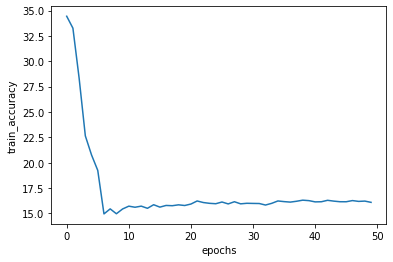

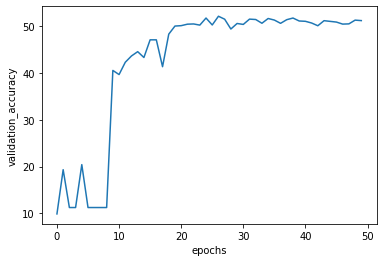

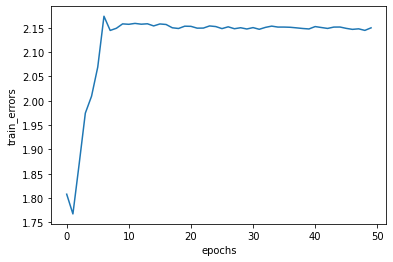

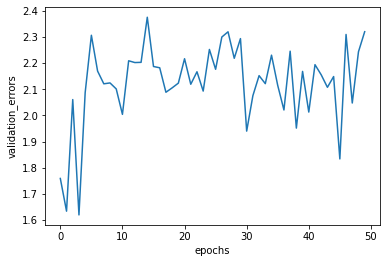

In [30]:
#Train the CNN
tr_avgLoss_list = []
tr_accuracy_list =[]
dev_avgLoss_list = []
dev_accuracy_list = []

#loop over epochs
for epoch in range(hyperparam.num_epochs):
    tr_num_correct = 0
    tr_num_samples = 0
    tr_total_loss = 0.0
    dev_num_correct = 0
    dev_num_samples = 0
    dev_total_loss = 0.0
    
    #Training
    cnn_model.train(True) 
    scheduler.step()  #to decrease the lr by 10% every 10 epochs because as you move towards the minima the steps size needs to decrease so it doesnt jump over the minima
    with torch.set_grad_enabled(True):
        for local_batch, local_labels in train_loader:
            local_batch=local_batch.unsqueeze(1)
            
            if torch.cuda.is_available():
              local_batch = local_batch.cuda()
              local_labels = local_labels.cuda()
            
            optimizer.zero_grad()
            
            
            local_batch = local_batch.float()
            local_labels = local_labels.float()
            #local_batch, local_labels = Variable(local_batch), Variable(local_labels)
            
            #Model computations
            out1 = cnn_model(local_batch)
            
            #Cross Entropy loss calculation
            ploss = criterion(out1, local_labels.long())
            tr_total_loss += ploss*hyperparam.bs
            
            #Backpropogation
            ploss.backward() #gradient calculation
            optimizer.step() #weight update
           
            
            sel_class = torch.argmax(out1, dim=1) #chooses the maximum value of the softmax layer
            
            tr_num_correct += sel_class.eq(local_labels).sum().item()
            tr_num_samples += hyperparam.bs
        
        tr_avgLoss = tr_total_loss/len(train_loader.dataset)
        tr_avgLoss_list.append(tr_avgLoss)
        
        tr_accuracy = tr_num_correct*100/tr_num_samples 
        tr_accuracy_list.append(tr_accuracy)

    #validation 
    with torch.set_grad_enabled(False):
      cnn_model.eval()

      for local_batch,local_labels in dev_loader:
        local_batch=local_batch.unsqueeze(1)

        local_batch=local_batch.float()
        local_labels=local_labels.float()
        #local_batch,local_labels=Variable(local_batch),Variable(local_labels)
        
        if torch.cuda.is_available():
            local_batch = local_batch.cuda()
            local_labels = local_labels.cuda()
        #Model computations2
        out1=cnn_model(local_batch)

        #CrossEntropy loss calculation
        pLoss=criterion(out1,local_labels.long())
        dev_total_loss +=ploss*hyperparam.bs
        sel_class=torch.argmax(out1,dim=1)

        dev_num_correct+=sel_class.eq(local_labels).sum().item()

        #print(correction)
        dev_num_samples+=hyperparam.bs

      dev_avgLoss=dev_total_loss/len(dev_loader.dataset)
      dev_avgLoss_list.append(dev_avgLoss)

      dev_accuracy=dev_num_correct*100/dev_num_samples
      dev_accuracy_list.append(dev_accuracy)
    print("accuracy",tr_accuracy,dev_accuracy)

plt.plot(np.arange(0,hyperparam.num_epochs,1),tr_accuracy_list)
plt.xlabel("epochs")
plt.ylabel("train_accuracy")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),dev_accuracy_list)
plt.xlabel("epochs")
plt.ylabel("validation_accuracy")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),tr_avgLoss_list)
plt.xlabel("epochs")
plt.ylabel("train_errors")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),dev_avgLoss_list)
plt.xlabel("epochs")
plt.ylabel("validation_errors")
plt.show()

### From the above diagram we can say that the model underfits as the accuracy and loss of both train and validation sets are not ideal. The accuracy decreased for the train set drastically at the start and then it increased a little then again decreased. The validation accuracy increased but since the train accuracy didn't increase we say that the model underfits.

In [31]:
def make_predictions(data_loader):
    cnn_model.eval()
    test_preds = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1) #adds a dimension of the length 1
        
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = cnn_model(data.float()) #convert to float here as well
        
        preds = output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
        
    return test_preds

In [32]:
test_set_preds = make_predictions(test_loader)
test_set_preds

tensor([[7],
        [7],
        [1],
        ...,
        [6],
        [3],
        [9]])

In [33]:
submission_df=pd.DataFrame()
submission_df["label"]=test_set_preds.numpy().squeeze()
submission_df.head()

,label
0,7
1,7
2,1
3,7
4,4


### Confusion Matrix of testing set
### Accuracy of the testing set

In [34]:
from sklearn.metrics import confusion_matrix

y_true = mnist["target"][60000:].astype(int)
y_pred = np.array(submission_df["label"])
cf = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true,y_pred)
print("Accuracy of the test set is:",acc*100,"%")
print("Confusion matrix for the test set: \n",cf)

Accuracy of the test set is: 50.349999999999994 %
Confusion matrix for the test set: 
 [[   0    3  105   18    0    0    0  837    5   12]
 [   0 1123    4    2    0    0    1    2    2    1]
 [   0    4  514  108    0    0    3  383    2   18]
 [   0    0   13  982    0    0    0    3    3    9]
 [   0    4    2    0  196    0  707    0    0   73]
 [   0    0    6  859    0    0    0    2    4   21]
 [   0   14   12   22  255    0  525    2    6  122]
 [   0   15   63   24    0    0    0  915    1   10]
 [   0    7   41  851    0    0    6    5   23   41]
 [   0   10    9   65    8    0  129    7   24  757]]


#### Thus, the accuracy of the baseline system is almost 50 which suggests that the model is not performing well. The confusion matrix suggests that for the number 0 & 5 there were no right predictions. Similarly, for others numbers the prediction is good whereas for others it is not good.